# SARSA with Kernel Function Approximation

This notebook shows the function approximation reinforcement learning algorithm, SARSA applied to the MountainCar problem (it also works on Acrobat and CartPole) from Open AI's gym. This algorithm is designed to work on state spaces larger than the tabular SARSA algorithm. It achieves this by representing the states by feature vectors, $x(s) = (x_{1}(s), x_{2}(s), ..., x_{n}(s))^T$, which is a vector with smaller size than the set of all states. 
Now the action value function can be estimated with function approximation, given by:
$$\hat{q}(s, a, \bold{w}) \approx q_{\pi}(s, a)$$
, where $\bold{w}$ is the parameter vector.

The parameter vector can then be updated using gradient descent:
$$\bold{w}_{t+1} = \bold{w}_{t} + \alpha [R_{t+1} + \gamma \hat{q}(S_{t + 1}, A_{t + 1}, \bold{w}_{t}) - \hat{q}(S_{t}, A_{t}, \bold{w}_{t})] \nabla \hat{q}(S_{t}, A_{t}, \bold{w}_{t})$$
, where $\bold{w}$ is the parameter vector, $\alpha$ is the step size, $\gamma$ is the discount rate, $R$ is the reward, $\nabla$ is the gradient operator, $S$ is the state, $A$ is the action and $\hat{q}$ is the approximate action-value function.

For more information on function approximation see section 10 of [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/RLbook2018.pdf). For alternative implementations of SARSA function approximation see: [Q-Learning Value Function Approximation Example by Denny Britz](https://github.com/dennybritz/reinforcement-learning/blob/master/FA/Q-Learning%20with%20Value%20Function%20Approximation%20Solution.ipynb).

In [17]:
import os
import gymnasium as gym
import numpy as np
import sklearn
import sklearn.pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler
from gymnasium.wrappers import RecordVideo
from IPython.display import Video
import matplotlib.pyplot as plt

In [18]:
# Type of environment, options include:
# MountainCar-v0, Acrobot-v1, CartPole-v1
ENV_TYPE = "MountainCar-v0"

# Save videos from training
SAVE_VIDEOS = False
VIDEOS_ROOT_DIR = './videos/sarsa_fa/'

In [19]:
# Create the environment
env = gym.make(ENV_TYPE, render_mode="rgb_array")

# Number of possible actions
num_actions = env.action_space.n

## Create Features Using Radial Basis Functions

In [20]:
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
observation_examples = np.array([np.float64(env.observation_space.sample()) for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# Used to convert a state to a featurizes represenation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(transformer_list=[('rbf1', RBFSampler(gamma=5.0)),
                               ('rbf2', RBFSampler(gamma=2.0)),
                               ('rbf3', RBFSampler()),
                               ('rbf4', RBFSampler(gamma=0.5))])

## Create Action-Value Function Approximator

In [21]:
def convert_to_features(state, scaler):
    """
    Converts the state to a feature representation.
    """
    scaled = scaler.transform([state])
    featurized = featurizer.transform(scaled)
    return featurized[0]    


In [22]:
# List of linear action-value fuction approximators (one for each action)
Q = []

for _ in range(num_actions):
    linear_model = SGDRegressor(learning_rate="constant")
    # We need to call partial_fit once to initialize the model
    # or we get a NotFittedError when trying to make a prediction
    # This is quite hacky.
    state, info = env.reset()
    linear_model.partial_fit([convert_to_features(state, scaler)], [0])
    Q.append(linear_model)    



In [23]:
def predict_returns(state, Q):
    features = convert_to_features(state, scaler)
    estimated_returns = []
    for linear_model in Q:
        estimated_returns.append(linear_model.predict([features])[0])

    return np.array(estimated_returns)

## Create An $\epsilon$-Greedy Policy 

In [24]:
def policy_fn(state, Q, epsilon, num_actions):
    # Create a distribution of actions and divide the epsilon probability between all actions
    action_dist = np.ones(num_actions, dtype=float) * epsilon / num_actions
    # Use function approximation to get the estimated returns for the actions in the current state
    estimated_returns = predict_returns(state, Q)
    # Find the best action
    best_action = np.argmax(estimated_returns)
    # Set probability for the best action to (1 - epsilon)
    action_dist[best_action] += (1.0 - epsilon)
    return action_dist

## Learn The Optimal Action-Value Function

In [25]:
# Number of episodes to train on
episodes = 41
# Return (accumulation of all rewards over an episode)
G = 0
returns = []
# Discount ratio
gamma = 0.99
# Probability of taking a non-greedy action
epsilon = 0.001

env = gym.make(ENV_TYPE, render_mode="rgb_array")
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=episodes)

if SAVE_VIDEOS:
    os.makedirs(VIDEOS_ROOT_DIR, exist_ok=True)
    env = gym.wrappers.RecordVideo(
        env=env, 
        video_folder=VIDEOS_ROOT_DIR,
        episode_trigger=lambda episode: episode % 10 == 0,
        video_length=0,
        name_prefix=ENV_TYPE
        )

        
for episode in range(1, episodes+1):
    terminated, truncated = False, False
    G, reward = 0, 0
    state, info = env.reset()
    action_dist = policy_fn(state, Q, epsilon, num_actions)
    action = np.random.choice(np.arange(num_actions), p=action_dist)

    while not terminated:
        # Take the action and observe reward and next state
        next_state, reward, terminated, truncated, info = env.step(action)
        # Select the action following the epsilon-greedy policy
        next_action_dist = policy_fn(next_state, Q, epsilon, num_actions)
        next_action = np.random.choice(np.arange(num_actions), p=next_action_dist)

        # Update the expected return for the action-value function
        next_estimated_returns = predict_returns(next_state, Q)
        td_target = reward + gamma * next_estimated_returns[next_action]
        Q[action].partial_fit([convert_to_features(state, scaler)], [td_target])
 
        G += reward
        state = next_state
        action = next_action

    returns.append(G)

    if episode % 1 == 0:
        print(f'Episode: {episode} Return: {G}')

Episode: 1 Return: -2671.0
Episode: 2 Return: -1407.0
Episode: 3 Return: -2264.0
Episode: 4 Return: -952.0
Episode: 5 Return: -522.0
Episode: 6 Return: -549.0
Episode: 7 Return: -353.0
Episode: 8 Return: -320.0
Episode: 9 Return: -326.0
Episode: 10 Return: -398.0
Episode: 11 Return: -350.0
Episode: 12 Return: -325.0
Episode: 13 Return: -165.0
Episode: 14 Return: -249.0
Episode: 15 Return: -264.0
Episode: 16 Return: -189.0
Episode: 17 Return: -161.0
Episode: 18 Return: -226.0
Episode: 19 Return: -286.0
Episode: 20 Return: -241.0
Episode: 21 Return: -140.0
Episode: 22 Return: -161.0
Episode: 23 Return: -198.0
Episode: 24 Return: -280.0
Episode: 25 Return: -233.0
Episode: 26 Return: -268.0
Episode: 27 Return: -183.0
Episode: 28 Return: -174.0
Episode: 29 Return: -154.0
Episode: 30 Return: -276.0
Episode: 31 Return: -112.0
Episode: 32 Return: -155.0
Episode: 33 Return: -143.0
Episode: 34 Return: -197.0
Episode: 35 Return: -154.0
Episode: 36 Return: -141.0
Episode: 37 Return: -158.0
Episode

## Plot The Results

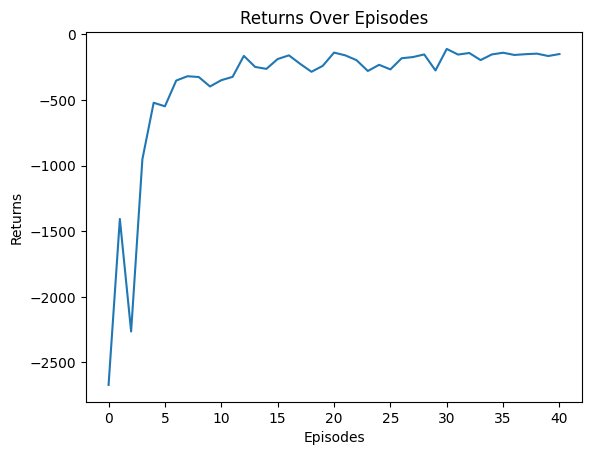

In [26]:
plt.plot(np.arange(episodes), returns)
plt.title("Returns Over Episodes")
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.show()

## Training Episode Videos

### Episode 0

In [27]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-0.mp4")

### Episide 10

In [28]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-10.mp4")

### Episode 20

In [29]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-20.mp4")

### Episode 30

In [30]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-30.mp4")

### Episode 40

In [31]:
Video(f"{VIDEOS_ROOT_DIR}/{ENV_TYPE}-episode-40.mp4")

## Run Greedily On An Example

In [32]:
# Run the algorithm in inferencing mode and 
# observe its performance
env = gym.make(ENV_TYPE, render_mode="human")
state, info = env.reset(seed=100)
G = 0
num_steps = 0
terminated = False
truncated = False

while not terminated and not truncated:
    estimated_returns = predict_returns(state, Q)
    action = np.argmax(estimated_returns) 
    state, reward, terminated, truncated, info = env.step(action)
    G += reward
    num_steps += 1

print(f'Total Reward: {G}, Steps Taken: {num_steps}')

env.close()

Total Reward: -90.0, Steps Taken: 90
